In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar  9 16:38:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# **Tutorial** - Topic Modeling with BERTopic
(last updated 08-06-2021)

In this tutorial we will be exploring how to use BERTopic to create topics from the well-known 20Newsgroups dataset. The most frequent use-cases and methods are discussed together with important parameters to keep a look out for. 


## BERTopic
BERTopic is a topic modeling technique that leverages 🤗 transformers and a custom class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. 

<br>

<img src="https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png" width="40%">

# Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

[Reference](https://colab.research.google.com/notebooks/gpu.ipynb)

# **Installing BERTopic**

We start by installing BERTopic from PyPi:

In [3]:
%%capture
!pip install bertopic
!pip install sentence_transformers

# INNER FUNCTIONS

In [4]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
from sklearn.utils import check_array
import numpy as np
import scipy.sparse as sp


class ClassTFIDF(TfidfTransformer):
    """
    A Class-based TF-IDF procedure using scikit-learns TfidfTransformer as a base.
    ![](../img/ctfidf.png)
    C-TF-IDF can best be explained as a TF-IDF formula adopted for multiple classes
    by joining all documents per class. Thus, each class is converted to a single document
    instead of set of documents. Then, the frequency of words **t** are extracted for
    each class **i** and divided by the total number of words **w**.
    Next, the total, unjoined, number of documents across all classes **m** is divided by the total
    sum of word **i** across all classes.
    """
    def __init__(self, *args, **kwargs):
        super(ClassTFIDF, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, multiplier: np.ndarray = None):
        """Learn the idf vector (global term weights).
        Arguments:
            X: A matrix of term/token counts.
            multiplier: A multiplier for increasing/decreasing certain IDF scores
        """
        X = check_array(X, accept_sparse=('csr', 'csc'))
        if not sp.issparse(X):
            X = sp.csr_matrix(X)
        dtype = np.float64

        if self.use_idf:
            _, n_features = X.shape

            # Calculate the frequency of words across all classes
            df = np.squeeze(np.asarray(X.sum(axis=0)))

            # Calculate the average number of samples as regularization
            avg_nr_samples = int(X.sum(axis=1).mean())

            # Divide the average number of samples by the word frequency
            # +1 is added to force values to be positive
            idf = np.log((avg_nr_samples / df)+1)

            # Multiplier to increase/decrease certain idf scores
            if multiplier is not None:
                idf = idf * multiplier

            self._idf_diag = sp.diags(idf, offsets=0,
                                      shape=(n_features, n_features),
                                      format='csr',
                                      dtype=dtype)

        return self

    def transform(self, X: sp.csr_matrix):
        """Transform a count-based matrix to c-TF-IDF
        Arguments:
            X (sparse matrix): A matrix of term/token counts.
        Returns:
            X (sparse matrix): A c-TF-IDF matrix
        """
        if self.use_idf:
            X = normalize(X, axis=1, norm='l1', copy=False)
            X = X * self._idf_diag

        return X

In [5]:
import numpy as np
import logging
from collections.abc import Iterable
from scipy.sparse.csr import csr_matrix


class MyLogger:
    def __init__(self, level):
        self.logger = logging.getLogger('BERTopic')
        self.set_level(level)
        self._add_handler()
        self.logger.propagate = False

    def info(self, message):
        self.logger.info("{}".format(message))

    def set_level(self, level):
        levels = ["DEBUG", "INFO", "WARNING", "ERROR", "CRITICAL"]
        if level in levels:
            self.logger.setLevel(level)

    def _add_handler(self):
        sh = logging.StreamHandler()
        sh.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(message)s'))
        self.logger.addHandler(sh)

        # Remove duplicate handlers
        if len(self.logger.handlers) > 1:
            self.logger.handlers = [self.logger.handlers[0]]


def check_documents_type(documents):
    """ Check whether the input documents are indeed a list of strings """
    if isinstance(documents, Iterable) and not isinstance(documents, str):
        if not any([isinstance(doc, str) for doc in documents]):
            raise TypeError("Make sure that the iterable only contains strings.")

    else:
        raise TypeError("Make sure that the documents variable is an iterable containing strings only.")


def check_embeddings_shape(embeddings, docs):
    """ Check if the embeddings have the correct shape """
    if embeddings is not None:
        if not any([isinstance(embeddings, np.ndarray), isinstance(embeddings, csr_matrix)]):
            raise ValueError("Make sure to input embeddings as a numpy array or scipy.sparse.csr.csr_matrix. ")
        else:
            if embeddings.shape[0] != len(docs):
                raise ValueError("Make sure that the embeddings are a numpy array with shape: "
                                 "(len(docs), vector_dim) where vector_dim is the dimensionality "
                                 "of the vector embeddings. ")


def check_is_fitted(model):
    """ Checks if the model was fitted by verifying the presence of self.matches
    Arguments:
        model: BERTopic instance for which the check is performed.
    Returns:
        None
    Raises:
        ValueError: If the matches were not found.
    """
    msg = ("This %(name)s instance is not fitted yet. Call 'fit' with "
           "appropriate arguments before using this estimator.")

    if not model.topics:
        raise ValueError(msg % {'name': type(model).__name__})


class NotInstalled:
    """
    This object is used to notify the user that additional dependencies need to be
    installed in order to use the string matching model.
    """

    def __init__(self, tool, dep):
        self.tool = tool
        self.dep = dep

        msg = f"In order to use {self.tool} you'll need to install via;\n\n"
        msg += f"pip install bertopic[{self.dep}]\n\n"
        self.msg = msg

    def __getattr__(self, *args, **kwargs):
        raise ModuleNotFoundError(self.msg)

    def __call__(self, *args, **kwargs):
        raise ModuleNotFoundError(self.msg)

In [6]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from typing import List


def mmr(doc_embedding: np.ndarray,
        word_embeddings: np.ndarray,
        words: List[str],
        top_n: int = 5,
        diversity: float = 0.8) -> List[str]:
    """ Calculate Maximal Marginal Relevance (MMR)
    between candidate keywords and the document.
    MMR considers the similarity of keywords/keyphrases with the
    document, along with the similarity of already selected
    keywords and keyphrases. This results in a selection of keywords
    that maximize their within diversity with respect to the document.
    Arguments:
        doc_embedding: The document embeddings
        word_embeddings: The embeddings of the selected candidate keywords/phrases
        words: The selected candidate keywords/keyphrases
        top_n: The number of keywords/keyhprases to return
        diversity: How diverse the select keywords/keyphrases are.
                   Values between 0 and 1 with 0 being not diverse at all
                   and 1 being most diverse.
    Returns:
         List[str]: The selected keywords/keyphrases
    """

    # Extract similarity within words, and between words and the document
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding)
    word_similarity = cosine_similarity(word_embeddings)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # Calculate MMR
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

In [7]:
import numpy as np
from typing import List


class BaseEmbedder:
    """ The Base Embedder used for creating embedding models
    Arguments:
        embedding_model: The main embedding model to be used for extracting
                         document and word embedding
        word_embedding_model: The embedding model used for extracting word
                              embeddings only. If this model is selected,
                              then the `embedding_model` is purely used for
                              creating document embeddings.
    """
    def __init__(self,
                 embedding_model=None,
                 word_embedding_model=None):
        self.embedding_model = embedding_model
        self.word_embedding_model = word_embedding_model

    def embed(self,
              documents: List[str],
              verbose: bool = False) -> np.ndarray:
        """ Embed a list of n documents/words into an n-dimensional
        matrix of embeddings
        Arguments:
            documents: A list of documents or words to be embedded
            verbose: Controls the verbosity of the process
        Returns:
            Document/words embeddings with shape (n, m) with `n` documents/words
            that each have an embeddings size of `m`
        """
        pass

    def embed_words(self,
                    words: List[str],
                    verbose: bool = False) -> np.ndarray:
        """ Embed a list of n words into an n-dimensional
        matrix of embeddings
        Arguments:
            words: A list of words to be embedded
            verbose: Controls the verbosity of the process
        Returns:
            Word embeddings with shape (n, m) with `n` words
            that each have an embeddings size of `m`
        """
        return self.embed(words, verbose)

    def embed_documents(self,
                        document: List[str],
                        verbose: bool = False) -> np.ndarray:
        """ Embed a list of n words into an n-dimensional
        matrix of embeddings
        Arguments:
            document: A list of documents to be embedded
            verbose: Controls the verbosity of the process
        Returns:
            Document embeddings with shape (n, m) with `n` documents
            that each have an embeddings size of `m`
        """
        return self.embed(document, verbose)

In [8]:
import numpy as np
from typing import List, Union
from sentence_transformers import SentenceTransformer

#from bertopic.backend import BaseEmbedder


class SentenceTransformerBackend(BaseEmbedder):
    """ Sentence-transformers embedding model
    The sentence-transformers embedding model used for generating document and
    word embeddings.
    Arguments:
        embedding_model: A sentence-transformers embedding model
    Usage:
    To create a model, you can load in a string pointing to a
    sentence-transformers model:
    ```python
    from bertopic.backend import SentenceTransformerBackend
    sentence_model = SentenceTransformerBackend("all-MiniLM-L6-v2")
    ```
    or  you can instantiate a model yourself:
    ```python
    from bertopic.backend import SentenceTransformerBackend
    from sentence_transformers import SentenceTransformer
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    sentence_model = SentenceTransformerBackend(embedding_model)
    ```
    """
    def __init__(self, embedding_model: Union[str, SentenceTransformer]):
        super().__init__()

        if isinstance(embedding_model, SentenceTransformer):
            self.embedding_model = embedding_model
        elif isinstance(embedding_model, str):
            #print(embedding_model)
            self.embedding_model = SentenceTransformer(embedding_model)
        else:
            raise ValueError("Please select a correct SentenceTransformers model: \n"
                             "`from sentence_transformers import SentenceTransformer` \n"
                             "`model = SentenceTransformer('all-MiniLM-L6-v2')`")

    def embed(self,
              documents: List[str],
              verbose: bool = False) -> np.ndarray:
        """ Embed a list of n documents/words into an n-dimensional
        matrix of embeddings
        Arguments:
            documents: A list of documents or words to be embedded
            verbose: Controls the verbosity of the process
        Returns:
            Document/words embeddings with shape (n, m) with `n` documents/words
            that each have an embeddings size of `m`
        """
        embeddings = self.embedding_model.encode(documents, show_progress_bar=verbose)
        return embeddings

In [9]:
#from ._base import BaseEmbedder
#from ._sentencetransformers import SentenceTransformerBackend

languages = ['afrikaans', 'albanian', 'amharic', 'arabic', 'armenian', 'assamese',
             'azerbaijani', 'basque', 'belarusian', 'bengali', 'bengali romanize',
             'bosnian', 'breton', 'bulgarian', 'burmese', 'burmese zawgyi font', 'catalan',
             'chinese (simplified)', 'chinese (traditional)', 'croatian', 'czech', 'danish',
             'dutch', 'english', 'esperanto', 'estonian', 'filipino', 'finnish', 'french',
             'galician', 'georgian', 'german', 'greek', 'gujarati', 'hausa', 'hebrew', 'hindi',
             'hindi romanize', 'hungarian', 'icelandic', 'indonesian', 'irish', 'italian', 'japanese',
             'javanese', 'kannada', 'kazakh', 'khmer', 'korean', 'kurdish (kurmanji)', 'kyrgyz',
             'lao', 'latin', 'latvian', 'lithuanian', 'macedonian', 'malagasy', 'malay', 'malayalam',
             'marathi', 'mongolian', 'nepali', 'norwegian', 'oriya', 'oromo', 'pashto', 'persian',
             'polish', 'portuguese', 'punjabi', 'romanian', 'russian', 'sanskrit', 'scottish gaelic',
             'serbian', 'sindhi', 'sinhala', 'slovak', 'slovenian', 'somali', 'spanish', 'sundanese',
             'swahili', 'swedish', 'tamil', 'tamil romanize', 'telugu', 'telugu romanize', 'thai',
             'turkish', 'ukrainian', 'urdu', 'urdu romanize', 'uyghur', 'uzbek', 'vietnamese',
             'welsh', 'western frisian', 'xhosa', 'yiddish']


def select_backend(embedding_model,
                   language: str = None) -> BaseEmbedder:
    """ Select an embedding model based on language or a specific sentence transformer models.
    When selecting a language, we choose all-MiniLM-L6-v2 for English and
    paraphrase-multilingual-MiniLM-L12-v2 for all other languages as it support 100+ languages.
    Returns:
        model: Either a Sentence-Transformer or Flair model
    """
    # BERTopic language backend
    if isinstance(embedding_model, BaseEmbedder):
        return embedding_model

    # Flair word embeddings
    if "flair" in str(type(embedding_model)):
        from bertopic.backend._flair import FlairBackend
        return FlairBackend(embedding_model)

    # Spacy embeddings
    if "spacy" in str(type(embedding_model)):
        from bertopic.backend._spacy import SpacyBackend
        return SpacyBackend(embedding_model)

    # Gensim embeddings
    if "gensim" in str(type(embedding_model)):
        from bertopic.backend._gensim import GensimBackend
        return GensimBackend(embedding_model)

    # USE embeddings
    if "tensorflow" and "saved_model" in str(type(embedding_model)):
        from bertopic.backend._use import USEBackend
        return USEBackend(embedding_model)

    # Sentence Transformer embeddings
    if "sentence_transformers" in str(type(embedding_model)):
        return SentenceTransformerBackend(embedding_model)

    # Create a Sentence Transformer model based on a string
    if isinstance(embedding_model, str):
        return SentenceTransformerBackend(embedding_model)

    # Select embedding model based on language
    if language:
        if language.lower() in ["English", "english", "en"]:
            return SentenceTransformerBackend("all-MiniLM-L6-v2")
        elif language.lower() in languages or language == "multilingual":
            return SentenceTransformerBackend("all-mpnet-base-v2")#"paraphrase-multilingual-MiniLM-L12-v2")
        else:
            raise ValueError(f"{language} is currently not supported. However, you can "
                             f"create any embeddings yourself and pass it through fit_transform(docs, embeddings)\n"
                             "Else, please select a language from the following list:\n"
                             f"{languages}")

    return SentenceTransformerBackend("all-MiniLM-L6-v2")

# MODEL

In [10]:
import yaml
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

try:
    yaml._warnings_enabled["YAMLLoadWarning"] = False
except (KeyError, AttributeError, TypeError) as e:
    pass

import re
import joblib
import inspect
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse.csr import csr_matrix
from typing import List, Tuple, Union, Mapping, Any

# Models
import hdbscan
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# BERTopic
#from bertopic._ctfidf import ClassTFIDF
#from bertopic._utils import MyLogger, check_documents_type, check_embeddings_shape, check_is_fitted
#from bertopic._mmr import mmr
#from bertopic.backend._utils import select_backend
#from bertopic import plotting

# Visualization
import plotly.graph_objects as go

logger = MyLogger("WARNING")


class myBERTopic:

    def __init__(self,
                 language: str = "english",
                 top_n_words: int = 10,
                 n_gram_range: Tuple[int, int] = (1, 1),
                 min_topic_size: int = 10,
                 nr_topics: Union[int, str] = None,
                 low_memory: bool = False,
                 calculate_probabilities: bool = False,
                 diversity: float = None,
                 seed_topic_list: List[List[str]] = None,
                 embedding_model=None,
                 umap_model: UMAP = None,
                 hdbscan_model: hdbscan.HDBSCAN = None,
                 vectorizer_model: CountVectorizer = None,
                 verbose: bool = False,
                 debug: bool = False
                 ):

        # Topic-based parameters
        if top_n_words > 30:
            raise ValueError("top_n_words should be lower or equal to 30. The preferred value is 10.")
        self.top_n_words = top_n_words
        self.min_topic_size = min_topic_size
        self.nr_topics = nr_topics
        self.low_memory = low_memory
        self.calculate_probabilities = calculate_probabilities
        self.diversity = diversity
        self.verbose = verbose
        self.seed_topic_list = seed_topic_list
        self.debug=debug

        # Embedding model
        self.language = language if not embedding_model else None
        self.embedding_model = embedding_model

        # Vectorizer
        self.n_gram_range = n_gram_range
        self.vectorizer_model = vectorizer_model or CountVectorizer(ngram_range=self.n_gram_range)

        # UMAP
        self.umap_model = umap_model or UMAP(n_neighbors=15,
                                             n_components=5,
                                             min_dist=0.0,
                                             metric='cosine',
                                             low_memory=self.low_memory)

        # HDBSCAN
        self.hdbscan_model = hdbscan_model or hdbscan.HDBSCAN(min_cluster_size=self.min_topic_size,
                                                              metric='euclidean',
                                                              cluster_selection_method='eom',
                                                              prediction_data=True)

        self.topics = None
        self.topic_mapper = None
        self.topic_sizes = None
        self.merged_topics = None
        self.topic_embeddings = None
        self.topic_sim_matrix = None
        self.representative_docs = None

        if verbose:
            logger.set_level("DEBUG")

    def fit(self,
            documents: List[str],
            embeddings: np.ndarray = None,
            y: Union[List[int], np.ndarray] = None):

        self.fit_transform(documents, embeddings, y)
        return self

    def fit_transform(self,
                      documents: List[str],
                      embeddings: np.ndarray = None,
                      y: Union[List[int], np.ndarray] = None) -> Tuple[List[int],
                                                                       Union[np.ndarray, None]]:
        if self.debug:                                                        
            print("FIT_TRANSFORM")
        check_documents_type(documents)
        check_embeddings_shape(embeddings, documents)

        documents = pd.DataFrame({"Document": documents,
                                  "ID": range(len(documents)),
                                  "Topic": None})
        if self.debug:
            print(documents.head(45))
        
        # Extract embeddings
        if embeddings is None:
            self.embedding_model = select_backend(self.embedding_model,
                                                  language=self.language)
            embeddings = self._extract_embeddings(documents.Document,
                                                  method="document",
                                                  verbose=self.verbose)
            logger.info("Transformed documents to Embeddings")
        else:
            if self.embedding_model is not None:
                self.embedding_model = select_backend(self.embedding_model,
                                                      language=self.language)
        if self.debug:
            print(self.embedding_model)
        # Reduce dimensionality with UMAP
        if self.seed_topic_list is not None and self.embedding_model is not None:
            y, embeddings = self._guided_topic_modeling(embeddings)
        umap_embeddings = self._reduce_dimensionality(embeddings, y)

        # Cluster UMAP embeddings with HDBSCAN
        documents, probabilities = self._cluster_embeddings(umap_embeddings, documents)

        if self.debug:
            print(documents.head(45))
        # Sort and Map Topic IDs by their frequency
        if not self.nr_topics:
            documents = self._sort_mappings_by_frequency(documents)

        # Extract topics by calculating c-TF-IDF
        self._extract_topics(documents)

        # Reduce topics
        if self.nr_topics:
            documents = self._reduce_topics(documents)

        self._map_representative_docs(original_topics=True)
        probabilities = self._map_probabilities(probabilities, original_topics=True)
        predictions = documents.Topic.to_list()

        return predictions, probabilities

    def transform(self,
                  documents: Union[str, List[str]],
                  embeddings: np.ndarray = None) -> Tuple[List[int], np.ndarray]:

        check_is_fitted(self)
        check_embeddings_shape(embeddings, documents)

        if isinstance(documents, str):
            documents = [documents]

        if embeddings is None:
            embeddings = self._extract_embeddings(documents,
                                                  method="document",
                                                  verbose=self.verbose)

        umap_embeddings = self.umap_model.transform(embeddings)
        logger.info("Reduced dimensionality with UMAP")

        predictions, probabilities = hdbscan.approximate_predict(self.hdbscan_model, umap_embeddings)
        logger.info("Predicted clusters with HDBSCAN")

        if self.calculate_probabilities:
            probabilities = hdbscan.membership_vector(self.hdbscan_model, umap_embeddings)
            logger.info("Calculated probabilities with HDBSCAN")
        else:
            probabilities = None

        probabilities = self._map_probabilities(probabilities, original_topics=True)
        predictions = self._map_predictions(predictions)
        return predictions, probabilities

    def topics_over_time(self,
                         docs: List[str],
                         topics: List[int],
                         timestamps: Union[List[str],
                                           List[int]],
                         nr_bins: int = None,
                         datetime_format: str = None,
                         evolution_tuning: bool = True,
                         global_tuning: bool = True) -> pd.DataFrame:

        check_is_fitted(self)
        check_documents_type(docs)
        documents = pd.DataFrame({"Document": docs, "Topic": topics, "Timestamps": timestamps})
        global_c_tf_idf = normalize(self.c_tf_idf, axis=1, norm='l1', copy=False)

        all_topics = sorted(list(documents.Topic.unique()))
        all_topics_indices = {topic: index for index, topic in enumerate(all_topics)}

        if isinstance(timestamps[0], str):
            infer_datetime_format = True if not datetime_format else False
            documents["Timestamps"] = pd.to_datetime(documents["Timestamps"],
                                                     infer_datetime_format=infer_datetime_format,
                                                     format=datetime_format)

        if nr_bins:
            documents["Bins"] = pd.cut(documents.Timestamps, bins=nr_bins)
            documents["Timestamps"] = documents.apply(lambda row: row.Bins.left, 1)

        # Sort documents in chronological order
        documents = documents.sort_values("Timestamps")
        timestamps = documents.Timestamps.unique()
        if len(timestamps) > 100:
            warnings.warn(f"There are more than 100 unique timestamps (i.e., {len(timestamps)}) "
                          "which significantly slows down the application. Consider setting `nr_bins` "
                          "to a value lower than 100 to speed up calculation. ")

        # For each unique timestamp, create topic representations
        topics_over_time = []
        for index, timestamp in tqdm(enumerate(timestamps), disable=not self.verbose):

            # Calculate c-TF-IDF representation for a specific timestamp
            selection = documents.loc[documents.Timestamps == timestamp, :]
            documents_per_topic = selection.groupby(['Topic'], as_index=False).agg({'Document': ' '.join,
                                                                                    "Timestamps": "count"})
            c_tf_idf, words = self._c_tf_idf(documents_per_topic, fit=False)

            if global_tuning or evolution_tuning:
                c_tf_idf = normalize(c_tf_idf, axis=1, norm='l1', copy=False)

            # Fine-tune the c-TF-IDF matrix at timestamp t by averaging it with the c-TF-IDF
            # matrix at timestamp t-1
            if evolution_tuning and index != 0:
                current_topics = sorted(list(documents_per_topic.Topic.values))
                overlapping_topics = sorted(list(set(previous_topics).intersection(set(current_topics))))

                current_overlap_idx = [current_topics.index(topic) for topic in overlapping_topics]
                previous_overlap_idx = [previous_topics.index(topic) for topic in overlapping_topics]

                c_tf_idf.tolil()[current_overlap_idx] = ((c_tf_idf[current_overlap_idx] +
                                                          previous_c_tf_idf[previous_overlap_idx]) / 2.0).tolil()

            # Fine-tune the timestamp c-TF-IDF representation based on the global c-TF-IDF representation
            # by simply taking the average of the two
            if global_tuning:
                selected_topics = [all_topics_indices[topic] for topic in documents_per_topic.Topic.values]
                c_tf_idf = (global_c_tf_idf[selected_topics] + c_tf_idf) / 2.0

            # Extract the words per topic
            labels = sorted(list(documents_per_topic.Topic.unique()))
            words_per_topic = self._extract_words_per_topic(words, c_tf_idf, labels)
            topic_frequency = pd.Series(documents_per_topic.Timestamps.values,
                                        index=documents_per_topic.Topic).to_dict()

            # Fill dataframe with results
            topics_at_timestamp = [(topic,
                                    ", ".join([words[0] for words in values][:5]),
                                    topic_frequency[topic],
                                    timestamp) for topic, values in words_per_topic.items()]
            topics_over_time.extend(topics_at_timestamp)

            if evolution_tuning:
                previous_topics = sorted(list(documents_per_topic.Topic.values))
                previous_c_tf_idf = c_tf_idf.copy()

        return pd.DataFrame(topics_over_time, columns=["Topic", "Words", "Frequency", "Timestamp"])

    def topics_per_class(self,
                         docs: List[str],
                         topics: List[int],
                         classes: Union[List[int], List[str]],
                         global_tuning: bool = True) -> pd.DataFrame:

        documents = pd.DataFrame({"Document": docs, "Topic": topics, "Class": classes})
        global_c_tf_idf = normalize(self.c_tf_idf, axis=1, norm='l1', copy=False)

        # For each unique timestamp, create topic representations
        topics_per_class = []
        for index, class_ in tqdm(enumerate(set(classes)), disable=not self.verbose):

            # Calculate c-TF-IDF representation for a specific timestamp
            selection = documents.loc[documents.Class == class_, :]
            documents_per_topic = selection.groupby(['Topic'], as_index=False).agg({'Document': ' '.join,
                                                                                    "Class": "count"})
            c_tf_idf, words = self._c_tf_idf(documents_per_topic, fit=False)

            # Fine-tune the timestamp c-TF-IDF representation based on the global c-TF-IDF representation
            # by simply taking the average of the two
            if global_tuning:
                c_tf_idf = normalize(c_tf_idf, axis=1, norm='l1', copy=False)
                c_tf_idf = (global_c_tf_idf[documents_per_topic.Topic.values + 1] + c_tf_idf) / 2.0

            # Extract the words per topic
            labels = sorted(list(documents_per_topic.Topic.unique()))
            words_per_topic = self._extract_words_per_topic(words, c_tf_idf, labels)
            topic_frequency = pd.Series(documents_per_topic.Class.values,
                                        index=documents_per_topic.Topic).to_dict()

            # Fill dataframe with results
            topics_at_class = [(topic,
                                ", ".join([words[0] for words in values][:5]),
                                topic_frequency[topic],
                                class_) for topic, values in words_per_topic.items()]
            topics_per_class.extend(topics_at_class)

        topics_per_class = pd.DataFrame(topics_per_class, columns=["Topic", "Words", "Frequency", "Class"])

        return topics_per_class

    def find_topics(self,
                    search_term: str,
                    top_n: int = 5) -> Tuple[List[int], List[float]]:

        if self.embedding_model is None:
            raise Exception("This method can only be used if you did not use custom embeddings.")

        topic_list = list(self.topics.keys())
        topic_list.sort()

        # Extract search_term embeddings and compare with topic embeddings
        search_embedding = self._extract_embeddings([search_term],
                                                    method="word",
                                                    verbose=False).flatten()
        sims = cosine_similarity(search_embedding.reshape(1, -1), self.topic_embeddings).flatten()

        # Extract topics most similar to search_term
        ids = np.argsort(sims)[-top_n:]
        similarity = [sims[i] for i in ids][::-1]
        similar_topics = [topic_list[index] for index in ids][::-1]

        return similar_topics, similarity

    def update_topics(self,
                      docs: List[str],
                      topics: List[int],
                      n_gram_range: Tuple[int, int] = None,
                      vectorizer_model: CountVectorizer = None):

        check_is_fitted(self)
        if not n_gram_range:
            n_gram_range = self.n_gram_range

        self.vectorizer_model = vectorizer_model or CountVectorizer(ngram_range=n_gram_range)

        documents = pd.DataFrame({"Document": docs, "Topic": topics})
        self._extract_topics(documents)

    def get_topics(self) -> Mapping[str, Tuple[str, float]]:

        check_is_fitted(self)
        return self.topics

    def get_topic(self, topic: int) -> Union[Mapping[str, Tuple[str, float]], bool]:

        check_is_fitted(self)
        if topic in self.topics:
            return self.topics[topic]
        else:
            return False

    def get_topic_info(self, topic: int = None) -> pd.DataFrame:

        check_is_fitted(self)

        info = pd.DataFrame(self.topic_sizes.items(), columns=['Topic', 'Count']).sort_values("Count", ascending=False)
        info["Name"] = info.Topic.map(self.topic_names)

        if topic:
            info = info.loc[info.Topic == topic, :]

        return info

    def get_topic_freq(self, topic: int = None) -> Union[pd.DataFrame, int]:

        check_is_fitted(self)
        if isinstance(topic, int):
            return self.topic_sizes[topic]
        else:
            return pd.DataFrame(self.topic_sizes.items(), columns=['Topic', 'Count']).sort_values("Count",
                                                                                                  ascending=False)

    def get_representative_docs(self, topic: int = None) -> List[str]:

        check_is_fitted(self)
        if isinstance(topic, int):
            return self.representative_docs[topic]
        else:
            return self.representative_docs

    def reduce_topics(self,
                      docs: List[str],
                      topics: List[int],
                      probabilities: np.ndarray = None,
                      nr_topics: int = 20) -> Tuple[List[int], np.ndarray]:

        check_is_fitted(self)
        self.nr_topics = nr_topics
        documents = pd.DataFrame({"Document": docs, "Topic": topics})

        # Reduce number of topics
        documents = self._reduce_topics(documents)
        self.merged_topics = None
        self._map_representative_docs()

        # Extract topics and map probabilities
        new_topics = documents.Topic.to_list()
        new_probabilities = self._map_probabilities(probabilities)

        return new_topics, new_probabilities

    def save(self,
             path: str,
             save_embedding_model: bool = True) -> None:

        with open(path, 'wb') as file:
            if not save_embedding_model:
                embedding_model = self.embedding_model
                self.embedding_model = None
                joblib.dump(self, file)
                self.embedding_model = embedding_model
            else:
                joblib.dump(self, file)

    @classmethod
    def load(cls,
             path: str,
             embedding_model=None):

        with open(path, 'rb') as file:
            if embedding_model:
                topic_model = joblib.load(file)
                topic_model.embedding_model = select_backend(embedding_model)
            else:
                topic_model = joblib.load(file)
            return topic_model

    def get_params(self, deep: bool = False) -> Mapping[str, Any]:

        out = dict()
        for key in self._get_param_names():
            value = getattr(self, key)
            if deep and hasattr(value, 'get_params'):
                deep_items = value.get_params().items()
                out.update((key + '__' + k, val) for k, val in deep_items)
            out[key] = value
        return out

    def _extract_embeddings(self,
                            documents: Union[List[str], str],
                            method: str = "document",
                            verbose: bool = None) -> np.ndarray:

        if isinstance(documents, str):
            documents = [documents]

        if method == "word":
            embeddings = self.embedding_model.embed_words(documents, verbose)
        elif method == "document":
            embeddings = self.embedding_model.embed_documents(documents, verbose)
        else:
            raise ValueError("Wrong method for extracting document/word embeddings. "
                             "Either choose 'word' or 'document' as the method. ")

        return embeddings

    def _map_predictions(self, predictions: List[int]) -> List[int]:

        mappings = self.topic_mapper.get_mappings(original_topics=True)
        mapped_predictions = [mappings[prediction]
                              if prediction in mappings
                              else -1
                              for prediction in predictions]
        return mapped_predictions

    def _reduce_dimensionality(self,
                               embeddings: Union[np.ndarray, csr_matrix],
                               y: Union[List[int], np.ndarray] = None) -> np.ndarray:

        if isinstance(embeddings, csr_matrix):
            self.umap_model = UMAP(n_neighbors=15,
                                   n_components=5,
                                   metric='hellinger',
                                   low_memory=self.low_memory).fit(embeddings, y=y)
        else:
            self.umap_model.fit(embeddings, y=y)
        umap_embeddings = self.umap_model.transform(embeddings)
        logger.info("Reduced dimensionality with UMAP")
        return np.nan_to_num(umap_embeddings)

    def _cluster_embeddings(self,
                            umap_embeddings: np.ndarray,
                            documents: pd.DataFrame) -> Tuple[pd.DataFrame,
                                                              np.ndarray]:

        self.hdbscan_model.fit(umap_embeddings)
        documents['Topic'] = self.hdbscan_model.labels_
        probabilities = self.hdbscan_model.probabilities_

        if self.calculate_probabilities:
            probabilities = hdbscan.all_points_membership_vectors(self.hdbscan_model)

        self._update_topic_size(documents)
        self._save_representative_docs(documents)
        self.topic_mapper = TopicMapper(self.hdbscan_model)
        logger.info("Clustered UMAP embeddings with HDBSCAN")
        return documents, probabilities

    def _guided_topic_modeling(self, embeddings: np.ndarray) -> Tuple[List[int], np.array]:

        # Create embeddings from the seeded topics
        seed_topic_list = [" ".join(seed_topic) for seed_topic in self.seed_topic_list]
        seed_topic_embeddings = self._extract_embeddings(seed_topic_list, verbose=self.verbose)
        seed_topic_embeddings = np.vstack([seed_topic_embeddings, embeddings.mean(axis=0)])

        # Label documents that are most similar to one of the seeded topics
        sim_matrix = cosine_similarity(embeddings, seed_topic_embeddings)
        y = [np.argmax(sim_matrix[index]) for index in range(sim_matrix.shape[0])]
        y = [val if val != len(seed_topic_list) else -1 for val in y]

        # Average the document embeddings related to the seeded topics with the
        # embedding of the seeded topic to force the documents in a cluster
        for seed_topic in range(len(seed_topic_list)):
            indices = [index for index, topic in enumerate(y) if topic == seed_topic]
            embeddings[indices] = np.average([embeddings[indices], seed_topic_embeddings[seed_topic]], weights=[3, 1])
        return y, embeddings

    def _extract_topics(self, documents: pd.DataFrame):

        documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
        self.c_tf_idf, words = self._c_tf_idf(documents_per_topic)
        self.topics = self._extract_words_per_topic(words)
        self._create_topic_vectors()
        self.topic_names = {key: f"{key}_" + "_".join([word[0] for word in values[:4]])
                            for key, values in
                            self.topics.items()}

    def _save_representative_docs(self, documents: pd.DataFrame):

        # Prepare the condensed tree and luf clusters beneath a given cluster
        condensed_tree = self.hdbscan_model.condensed_tree_
        raw_tree = condensed_tree._raw_tree
        clusters = sorted(condensed_tree._select_clusters())
        cluster_tree = raw_tree[raw_tree['child_size'] > 1]

        #  Find the points with maximum lambda value in each leaf
        representative_docs = {}
        for topic in documents['Topic'].unique():
            if topic != -1:
                leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, clusters[topic])

                result = np.array([])
                for leaf in leaves:
                    max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
                    points = raw_tree['child'][(raw_tree['parent'] == leaf) & (raw_tree['lambda_val'] == max_lambda)]
                    result = np.hstack((result, points))

                representative_docs[topic] = list(np.random.choice(result, 1, replace=False).astype(int))

        # Convert indices to documents
        self.representative_docs = {topic: [documents.iloc[doc_id].Document for doc_id in doc_ids]
                                    for topic, doc_ids in
                                    representative_docs.items()}

    def _map_representative_docs(self, original_topics: bool = False):

        mappings = self.topic_mapper.get_mappings(original_topics)
        representative_docs = self.representative_docs.copy()

        # Update the representative documents
        updated_representative_docs = {mappings[old_topic]: []
                                       for old_topic, _ in representative_docs.items()}
        for old_topic, docs in representative_docs.items():
            new_topic = mappings[old_topic]
            updated_representative_docs[new_topic].extend(docs)

        self.representative_docs = updated_representative_docs

    def _create_topic_vectors(self):

        if self.embedding_model is not None:
            topic_list = list(self.topics.keys())
            topic_list.sort()
            n = self.top_n_words

            # Extract embeddings for all words in all topics
            topic_words = [self.get_topic(topic) for topic in topic_list]
            topic_words = [word[0] for topic in topic_words for word in topic]
            embeddings = self._extract_embeddings(topic_words,
                                                  method="word",
                                                  verbose=False)

            # Take the weighted average of word embeddings in a topic based on their c-TF-IDF value
            # The embeddings var is a single numpy matrix and therefore slicing is necessary to
            # access the words per topic
            topic_embeddings = []
            for i, topic in enumerate(topic_list):
                word_importance = [val[1] for val in self.get_topic(topic)]
                if sum(word_importance) == 0:
                    word_importance = [1 for _ in range(len(self.get_topic(topic)))]
                topic_embedding = np.average(embeddings[i * n: n + (i * n)], weights=word_importance, axis=0)
                topic_embeddings.append(topic_embedding)

            self.topic_embeddings = topic_embeddings

    def _c_tf_idf(self, documents_per_topic: pd.DataFrame, fit: bool = True) -> Tuple[csr_matrix, List[str]]:
        if self.debug:
            print("C_TF_IDF")
        documents = self._preprocess_text(documents_per_topic.Document.values)
        if self.debug:
            print(documents)
        if fit:
            self.vectorizer_model.fit(documents)

        words = self.vectorizer_model.get_feature_names()
        if self.debug:
            print(words)
        X = self.vectorizer_model.transform(documents)

        if self.seed_topic_list:
            seed_topic_list = [seed for seeds in self.seed_topic_list for seed in seeds]
            multiplier = np.array([1.2 if word in seed_topic_list else 1 for word in words])
        else:
            multiplier = None

        if fit:
            self.transformer = ClassTFIDF().fit(X, multiplier=multiplier)

        c_tf_idf = self.transformer.transform(X)

        self.topic_sim_matrix = cosine_similarity(c_tf_idf)

        return c_tf_idf, words

    def _update_topic_size(self, documents: pd.DataFrame):

        sizes = documents.groupby(['Topic']).count().sort_values("Document", ascending=False).reset_index()
        self.topic_sizes = dict(zip(sizes.Topic, sizes.Document))

    def _extract_words_per_topic(self,
                                 words: List[str],
                                 c_tf_idf: csr_matrix = None,
                                 labels: List[int] = None) -> Mapping[str,
                                                                      List[Tuple[str, float]]]:
        if self.debug:
            print("EXTRACT WORDS PER TOPIC")
        if c_tf_idf is None:
            c_tf_idf = self.c_tf_idf

        if labels is None:
            labels = sorted(list(self.topic_sizes.keys()))
        
        if self.debug:
            print(words)
        # Get the top 30 indices and values per row in a sparse c-TF-IDF matrix
        indices = self._top_n_idx_sparse(c_tf_idf, 30)
        scores = self._top_n_values_sparse(c_tf_idf, indices)
        sorted_indices = np.argsort(scores, 1)
        indices = np.take_along_axis(indices, sorted_indices, axis=1)
        scores = np.take_along_axis(scores, sorted_indices, axis=1)

        # Get top 30 words per topic based on c-TF-IDF score
        topics = {label: [(words[word_index], score)
                          if word_index and score > 0
                          else ("", 0.00001)
                          for word_index, score in zip(indices[index][::-1], scores[index][::-1])
                          ]
                  for index, label in enumerate(labels)}

        # Extract word embeddings for the top 30 words per topic and compare it
        # with the topic embedding to keep only the words most similar to the topic embedding
        if self.diversity is not None:
            if self.embedding_model is not None:

                for topic, topic_words in topics.items():
                    words = [word[0] for word in topic_words]
                    word_embeddings = self._extract_embeddings(words,
                                                            method="word",
                                                            verbose=False)
                    print(word_embeddings)
                    topic_embedding = self._extract_embeddings(" ".join(words),
                                                            method="word",
                                                            verbose=False).reshape(1, -1)
                    topic_words = mmr(topic_embedding, word_embeddings, words,
                                    top_n=self.top_n_words, diversity=self.diversity)
                    topics[topic] = [(word, value) for word, value in topics[topic] if word in topic_words]
        topics = {label: values[:self.top_n_words] for label, values in topics.items()}

        return topics

    def _reduce_topics(self, documents: pd.DataFrame) -> pd.DataFrame:

        initial_nr_topics = len(self.get_topics())

        if isinstance(self.nr_topics, int):
            if self.nr_topics < initial_nr_topics:
                documents = self._reduce_to_n_topics(documents)
        elif isinstance(self.nr_topics, str):
            documents = self._auto_reduce_topics(documents)
        else:
            raise ValueError("nr_topics needs to be an int or 'auto'! ")

        logger.info(f"Reduced number of topics from {initial_nr_topics} to {len(self.get_topic_freq())}")
        return documents

    def _reduce_to_n_topics(self, documents: pd.DataFrame) -> pd.DataFrame:

        # Track which topics where originally merged
        if not self.merged_topics:
            self.merged_topics = []

        # Create topic similarity matrix
        similarities = cosine_similarity(self.c_tf_idf)
        np.fill_diagonal(similarities, 0)

        # Find most similar topic to least common topic
        topics = documents.Topic.tolist().copy()
        mapped_topics = {}
        while len(self.get_topic_freq()) > self.nr_topics + 1:
            topic_to_merge = self.get_topic_freq().iloc[-1].Topic
            topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1
            similarities[:, topic_to_merge + 1] = -1
            self.merged_topics.append(topic_to_merge)

            # Update Topic labels
            documents.loc[documents.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
            mapped_topics[topic_to_merge] = topic_to_merge_into
            self._update_topic_size(documents)

        # Map topics
        mapped_topics = {from_topic: to_topic for from_topic, to_topic in zip(topics, documents.Topic.tolist())}
        self.topic_mapper.add_mappings(mapped_topics)

        # Update representations
        documents = self._sort_mappings_by_frequency(documents)
        self._extract_topics(documents)
        self._update_topic_size(documents)
        return documents

    def _auto_reduce_topics(self, documents: pd.DataFrame) -> pd.DataFrame:

        topics = documents.Topic.tolist().copy()
        unique_topics = sorted(list(documents.Topic.unique()))[1:]
        max_topic = unique_topics[-1]

        # Find similar topics
        if self.topic_embeddings is not None:
            embeddings = np.array(self.topic_embeddings)
        else:
            embeddings = self.c_tf_idf.toarray()
        norm_data = normalize(embeddings, norm='l2')
        predictions = hdbscan.HDBSCAN(min_cluster_size=2,
                                      metric='euclidean',
                                      cluster_selection_method='eom',
                                      prediction_data=True).fit_predict(norm_data[1:])

        # Map similar topics
        mapped_topics = {unique_topics[index]: prediction + max_topic
                         for index, prediction in enumerate(predictions)
                         if prediction != -1}
        documents.Topic = documents.Topic.map(mapped_topics).fillna(documents.Topic).astype(int)
        mapped_topics = {from_topic: to_topic for from_topic, to_topic in zip(topics, documents.Topic.tolist())}

        # Update documents and topics
        self.topic_mapper.add_mappings(mapped_topics)
        documents = self._sort_mappings_by_frequency(documents)
        self._extract_topics(documents)
        self._update_topic_size(documents)
        return documents

    def _sort_mappings_by_frequency(self, documents: pd.DataFrame) -> pd.DataFrame:

        self._update_topic_size(documents)

        # Map topics based on frequency
        df = pd.DataFrame(self.topic_sizes.items(), columns=["Old_Topic", "Size"]).sort_values("Size", ascending=False)
        df = df[df.Old_Topic != -1]
        sorted_topics = {**{-1: -1}, **dict(zip(df.Old_Topic, range(len(df))))}
        self.topic_mapper.add_mappings(sorted_topics)

        # Map documents
        documents.Topic = documents.Topic.map(sorted_topics).fillna(documents.Topic).astype(int)
        self._update_topic_size(documents)
        return documents

    def _map_probabilities(self,
                           probabilities: Union[np.ndarray, None],
                           original_topics: bool = False) -> Union[np.ndarray, None]:

        mappings = self.topic_mapper.get_mappings(original_topics)

        # Map array of probabilities (probability for assigned topic per document)
        if probabilities is not None:
            if len(probabilities.shape) == 2 and self.get_topic(-1):
                mapped_probabilities = np.zeros((probabilities.shape[0],
                                                 len(set(mappings.values())) - 1))
                for from_topic, to_topic in mappings.items():
                    if to_topic != -1 and from_topic != -1:
                        mapped_probabilities[:, to_topic] += probabilities[:, from_topic]

                return mapped_probabilities

        return probabilities

    def _preprocess_text(self, documents: np.ndarray) -> List[str]:
        if self.debug:
            print("\nPREPROCESS TEXT")
            print("LEN DOCS:",len(documents))
            print(0)
            for doc in documents:
                print(doc)
        cleaned_documents = [doc.lower() for doc in documents]
        if self.debug:
            print(1)
            for doc in cleaned_documents:
                print(doc)
        cleaned_documents = [doc.replace("\n", " ") for doc in cleaned_documents]
        if self.debug:
            print(2)
            for doc in cleaned_documents:
                print(doc)
        cleaned_documents = [doc.replace("\t", " ") for doc in cleaned_documents]
        if self.debug:
            print(3)
            for doc in cleaned_documents:
                print(doc)

        if self.language == "english":
            cleaned_documents = [re.sub(r'[^A-Za-z0-9_]+', ' ', doc) for doc in cleaned_documents]

        if self.debug:
            print(4)
            for doc in cleaned_documents:
                print(doc)
        cleaned_documents = [doc if doc != "" else "emptydoc" for doc in cleaned_documents]
        if self.debug:
            print(5)
            for doc in cleaned_documents:
                print(doc)
            print("END PREPROCESS TEXT\n")
        return cleaned_documents

    @staticmethod
    def _top_n_idx_sparse(matrix: csr_matrix, n: int) -> np.ndarray:

        indices = []
        for le, ri in zip(matrix.indptr[:-1], matrix.indptr[1:]):
            n_row_pick = min(n, ri - le)
            values = matrix.indices[le + np.argpartition(matrix.data[le:ri], -n_row_pick)[-n_row_pick:]]
            values = [values[index] if len(values) >= index + 1 else None for index in range(n)]
            indices.append(values)
        return np.array(indices)

    @staticmethod
    def _top_n_values_sparse(matrix: csr_matrix, indices: np.ndarray) -> np.ndarray:

        top_values = []
        for row, values in enumerate(indices):
            scores = np.array([matrix[row, value] if value is not None else 0 for value in values])
            top_values.append(scores)
        return np.array(top_values)

    @classmethod
    def _get_param_names(cls):

        init_signature = inspect.signature(cls.__init__)
        parameters = sorted([p.name for p in init_signature.parameters.values()
                             if p.name != 'self' and p.kind != p.VAR_KEYWORD])
        return parameters

    def __str__(self):

        parameters = ""
        for parameter, value in self.get_params().items():
            value = str(value)
            if "(" in value and value[0] != "(":
                value = value.split("(")[0] + "(...)"
            parameters += f"{parameter}={value}, "

        return f"BERTopic({parameters[:-2]})"


class TopicMapper:

    def __init__(self, hdbscan_model: hdbscan.HDBSCAN):

        self.base_topics = np.array(sorted(list(set(hdbscan_model.labels_))))
        topics = self.base_topics.copy().reshape(-1, 1)
        self.mappings = np.hstack([topics.copy(), topics.copy()]).tolist()

    def get_mappings(self, original_topics: bool = True) -> Mapping[int, int]:

        if original_topics:
            mappings = np.array(self.mappings)[:, [0, -1]]
            mappings = dict(zip(mappings[:, 0], mappings[:, 1]))
        else:
            mappings = np.array(self.mappings)[:, [-3, -1]]
            mappings = dict(zip(mappings[:, 0], mappings[:, 1]))
        return mappings

    def add_mappings(self, mappings: Mapping[int, int]):

        for topics in self.mappings:
            topic = topics[-1]
            if topic in mappings:
                topics.append(mappings[topic])
            else:
                topics.append(-1)

## Restart the Notebook
After installing BERTopic, some packages that were already loaded were updated and in order to correctly use them, we should now restart the notebook.

From the Menu:

Runtime → Restart Runtime

In [11]:
from sklearn.datasets import fetch_20newsgroups
ordocs = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))['data']

In [12]:
print(type(ordocs), len(ordocs))

<class 'list'> 18846


In [13]:
print(ordocs[0])



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




# My Dataset

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/T2V/

 BERTopic.ipynb
 bertopic.model
 best_bertopic.model
 best_ertopic.model
'Copia di BERTopic.ipynb'
 HDFS_best_bertopic_MESSAGE.model
 HDFS_best_bertopic_ORIGIN+MESSAGE.model
 HDFS_best_bertopic_SPLIT.model
 Input
 Spark_best_bertopic_MESSAGE.model
 Spark_best_bertopic_ORIGIN+MESSAGE.model
 Spark_best_bertopic_SPLIT.model
 Top2Vec.ipynb


In [16]:
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/T2V/

/content/gdrive/My Drive/Colab Notebooks/T2V


In [17]:
pathname="/content/gdrive/MyDrive/Colab Notebooks/T2V"

In [41]:
name="HDFS"
tipo="SPLIT"

In [42]:
topic_model=myBERTopic.load(f"{name}_best_bertopic_{tipo}.model")

In [43]:
print("K:",topic_model.nr_topics)
print("NC:",topic_model.umap_model.n_components)
print("NN:",topic_model.umap_model.n_neighbors)

K: 50
NC: 10
NN: 14


In [ ]:
f=open(pathname+f"/Input/{name}/{tipo}/{name}_InputData_{tipo}.txt","r")
lines=f.readlines()
sentences=[]
token_lists=[]
idx_in=[]
for i,line in enumerate(lines):
  line=line.rstrip("\n")
  #print(i,type(line),line)
  row_tk=[]
  for el in line.split(", "):
    el=el.replace("[","")
    el=el.replace("]","")
    el=el.replace("'","")
    el=el.replace(" ","_")
    row_tk.append(el)
  #print(i,type(row_tk),row_tk)
  sent=" ".join(row_tk)
  #print(i,sent,"\n")
  sentences.append(sent)
  token_lists.append(row_tk)
  idx_in.append(i)
f.close()
print(len(sentences))

98


In [ ]:
f=open(pathname+f"/Input/{name}/{tipo}/{name}_Raw_{tipo}.txt","r")
lines=f.readlines()
originals=[]
for i,line in enumerate(lines):
  line=line.rstrip("\n")
  #print(line)
  originals.append(line)
f.close()
print(len(originals))

98


In [ ]:
import pickle
from scipy import spatial
import seaborn as sns
f=open(pathname+f"/Input/{name}/{tipo}/{name}_w2vdict_{tipo}.pkl","rb")
modelW2V=pickle.load(f)
#print(modelW2V)
print(type(modelW2V))
print(modelW2V.keys())
print(len(modelW2V))
print([el for el in modelW2V.keys() if "start" in el])

<class 'dict'>
dict_keys(['service_try_claim', 'src_dest', 'not_replicate_block', 'eof_exception_detail', 'exception_offer_service', 'time_scan', 'add_new', 'service_register_nn', 'record_length', 'block_receiver', 'signer_secret', 'volume_storage', 'dfs', 'ipc', 'scan', 'ipc_server_responder', 'start_interval', 'persist', 'blockreport_interval', 'open_stream', 'add_filter', 'exception_java', 'slow_manage', 'storage', 'analyze_storage_directory', 'local', 'shorter_namenode_record', 'trash', 'timeout_wait_channel', 'command_action_register', 'block_pool_find', 'pool_service_begin', 'total_block_miss', 'responder_start', 'thread_balance', 'max_lock_memory', 'random_secret', 'blockreport_interval_cachereport', 'initialize', 'cache', 'write_packet_mirror', 'action_register_active', 'block_volume', 'command', 'pool_service_try', 'start_offer', 'scan_block', 'manage_writer_os', 'read_java_channel', 'new_datanode', 'bandwith', 'file_signer', 'queue_class', 'lock_acquire_nodename', 'operation'

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def CLUSTERSIMILARITY(tp, modelW2V):
    similarities2=[]
    for i,top_wrd in enumerate(tp):
        tmp=tp
        tmp_sim=[]
        curr_v=np.zeros(300)
        num_words=0
        for el in top_wrd:
          if el in modelW2V.keys():
            word_vec=modelW2V[el]
            curr_v+=word_vec
            num_words+=1
        curr_v=curr_v/num_words
        for j,other_topic in enumerate(tmp):
            act_v=np.zeros(300)
            num_words=0
            for el in other_topic:
              if el in modelW2V.keys():
                word_vec=modelW2V[el]
                act_v+=word_vec
                num_words+=1
            act_v=act_v/num_words
            similarity=spatial.distance.cosine(curr_v, act_v)
            similarity=round(1-similarity,4)
            tmp_sim.append(similarity)
        similarities2.append(tmp_sim)


    with sns.axes_style("darkgrid"):
        mask = np.triu(np.ones_like(similarities2, dtype=bool),k=1)
        plt.figure(figsize=(20,20), dpi=80)
        cmap=sns.diverging_palette(240, 10, n=9)
        sns.heatmap(similarities2,annot=True,mask=mask,cmap=cmap,linewidth=2,edgecolor="k",vmin=-1,vmax=1,center=0)
        plt.title("Similarity between Topics")
        plt.show()
    

    similarities2=pd.DataFrame(similarities2)
    upper_tri = similarities2.where(np.triu(np.ones(similarities2.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)] #MORE THAN 90% of WORD IN COMMON
    similarities2_dropped=similarities2.drop(columns=to_drop)
    delta_k=len(to_drop)
    print(f"Features to be dropped:{to_drop} - {len(to_drop)}\n")
    
    return delta_k,to_drop

In [ ]:
def CLUSTERSIMILARITY2(tp, modelW2V):
    similarities2=[]
    max=[]
    for i,top_wrd in enumerate(tp):
        tmp=tp
        tmp_sim=[]
        curr_v=np.zeros(300)
        num_words=0
        for el in top_wrd:
            word_vec=modelW2V[el]
            curr_v+=word_vec
            num_words+=1
        curr_v=curr_v/num_words
        for j,other_topic in enumerate(tmp):
            act_v=np.zeros(300)
            num_words=0
            for el in other_topic:
                word_vec=modelW2V[el]
                act_v+=word_vec
                num_words+=1
            act_v=act_v/num_words
            similarity=spatial.distance.cosine(curr_v, act_v)
            similarity=round(1-similarity,4)

            flag=0
            for el in top_wrd:
                if el in other_topic:
                    flag+=1
            if flag==len(top_wrd) and i!=j and "supergroup" in top_wrd:
                print(f"ALL ELEMENT OF TOPIC {i} ARE INSIDE TOPIC {j}")
                print(i,top_wrd)
                print(j,other_topic)
                tmp_sim.append(-1)
            else:
                tmp_sim.append(similarity)
            if j!=i:
                max.append(similarity)
        similarities2.append(tmp_sim)

    max=np.array(max)
    max=-np.sort(-max)
    max5=max[:5]
    similarities2=pd.DataFrame(similarities2)
    upper_tri = similarities2.where(np.triu(np.ones(similarities2.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)] #MORE THAN 90% of WORD IN COMMON
    similarities2_dropped=similarities2.drop(columns=to_drop)
    delta_k=len(to_drop)
    print(f"Features to be dropped:{to_drop} - {len(to_drop)} - max: {max5}")
    
    return delta_k,to_drop

# **Topic Modeling**

In this example, we will go through the main components of BERTopic and the steps necessary to create a strong topic model. 




## Training

We start by instantiating BERTopic. We set language to `english` since our documents are in the English language. If you would like to use a multi-lingual model, please use `language="multilingual"` instead. 

We will also calculate the topic probabilities. However, this can slow down BERTopic significantly at large amounts of data (>100_000 documents). It is advised to turn this off if you want to speed up the model. 


In [ ]:
pd.set_option("display.max_rows",None,"display.max_columns",None)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
def get_coherence(tw, tl, measure='c_v', topk=20):
    dictionary = corpora.Dictionary(tl)
    corpus = [dictionary.doc2bow(text) for text in tl]

    cm = CoherenceModel(topics=tw, texts = tl, corpus=corpus, dictionary=dictionary, coherence = measure, topn=topk)

    return cm.get_coherence()

In [ ]:
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine',random_state=113)

from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [ ]:
MUL=15
sentences2=sentences*MUL
print(len(sentences2))

1470


In [ ]:
#from bertopic import BERTopic
import random as rn
rn.seed(0)
np.random.seed(0)
topic_model = myBERTopic(language="english", calculate_probabilities=True, verbose=True, top_n_words=20,hdbscan_model=hdbscan_model,umap_model=umap_model, debug=False)
topics, probs = topic_model.fit_transform(sentences2)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

2022-02-03 15:43:11,123 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-02-03 15:43:27,475 - BERTopic - Reduced dimensionality with UMAP
2022-02-03 15:43:29,719 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
num_topic=topic_model.get_topics()
print(len(num_topic))

87


In [ ]:
print(len(topics))

675


In [ ]:
topics_words=[]
for i in range(0,len(num_topic)-1):
    tw=[]
    print(i,topic_model.get_topic(i),len(topic_model.get_topic(i)))
    for el in topic_model.get_topic(i):
        if len(el[0])>0:
            tw.append(el[0])
    print(i,tw,len(tw))
    print("\n")
    topics_words.append(tw)

cohe= get_coherence(topics_words, token_lists, 'c_v', topk=20)
print(cohe)

In [ ]:
delta_k,to_drop=CLUSTERSIMILARITY2(topics_words, modelW2V)

Features to be dropped:[10, 19, 25, 26, 29, 33, 35, 37, 38, 41, 42, 43, 44, 46, 47, 49, 50, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85] - 50 - max: [1. 1. 1. 1. 1.]



In [ ]:
topics45=topics[:45]
indexes=np.argsort(topics45)
print(len(indexes))

45


In [ ]:
for i in indexes:
    print(topics[i], max(probs[i]))
    print(topic_model.get_topic(topics[i]))
    print(sentences2[i])
    print(originals[i])
    print("\n")

In [ ]:
Upper=0
if len(sentences)<len(num_topic):
  Upper=len(sentences)+1
else:
  Upper=len(num_topic)

reduction=np.arange(10,Upper,1)
reduction=-np.sort(-reduction)
print(reduction)

[45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22
 21 20 19 18 17 16 15 14 13 12 11 10]


In [ ]:
topic_model.save("bertopic.model")

In [ ]:
best_cohe=0
nt=0
best_red=0
for red in reduction:

    print("-"*30)

    model2=myBERTopic.load("bertopic.model")
    new_topics, new_probs = model2.reduce_topics(sentences2, topics, probs, nr_topics=int(red)-1)

    num_topic=model2.get_topics()
    print(red, len(model2.get_topics()), len(topic_model.get_topics()))

    tops_words=[]
    for i in range(0,len(num_topic)-1):
        tw=[]
        for el in model2.get_topic(i):
            if len(el[0])>0:
                tw.append(el[0])
        tops_words.append(tw)
            

    cohe= get_coherence(tops_words, token_lists, 'c_v', topk=20)
    delta_k,to_drop=CLUSTERSIMILARITY2(tops_words, modelW2V)
    if cohe>best_cohe and delta_k==0:
        best_cohe=cohe
        best_red=red
        nt=red
        print("--> [BEST] COHERENCE:",cohe)
    else:
        print("COHERENCE:",cohe)



## FINAL  TRAIN

In [ ]:
#SPARK
'''
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine',random_state=113)

from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
'''

In [ ]:
#HDFS
from umap import UMAP
umap_model = UMAP(n_neighbors=10, n_components=10, min_dist=0.0, metric='cosine',random_state=113)

from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [ ]:
'''
HDSF SPLIT
m=np.arange(4,20,2)
nt=np.arange(44,80,2)
nn=np.arange(12,15,1)
print(nn)
print(m)
print(nt)

HDFS ORIGIN+MESSAGE
'''

'\nHDSF SPLIT\nm=np.arange(4,20,2)\nnt=np.arange(44,80,2)\nnn=np.arange(12,15,1)\nprint(nn)\nprint(m)\nprint(nt)\n\nHDFS ORIGIN+MESSAGE\n'

In [ ]:
m=np.arange(10,20,2)
nt=np.arange(44,80,2)
nn=np.arange(12,15,1)
print(nn)
print(m)
print(nt)


[12 13 14]
[10 12 14 16 18]
[44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78]


In [ ]:
import random as rn
best_cohe=0
best_k=0
best_MUL=0
best_nn=0

for num_n in [9]:
    umap_model = UMAP(n_neighbors=num_n, n_components=10, min_dist=0.0, metric='cosine',random_state=113)
    print("%+"*67)
    print("UMAP WITH NN:", num_n)

    for MUL in [10]:
        sentences3=sentences*int(MUL)
        print("#"*113)
        print(MUL,len(sentences3))

        for k in [44]:#range(50,99):
            rn.seed(0)
            np.random.seed(0)
            print("-"*113)
            #print("MUL:",MUL,"NUM TOPIC:",k)
            topic_model = myBERTopic(language="english", calculate_probabilities=True, verbose=True, top_n_words=20, hdbscan_model=hdbscan_model, umap_model=umap_model, debug=False, nr_topics=int(k))
            topics, probs = topic_model.fit_transform(sentences3)

            num_topic=topic_model.get_topics()
            #print("\nCHECK CONSISTENCY NUM TOPICS",len(num_topic)-1, k,"\n")

            topics_words=[]
            for i in range(0,len(num_topic)-1):
                tw=[]
                #print(i,topic_model.get_topic(i),len(topic_model.get_topic(i)))
                for el in topic_model.get_topic(i):
                    if len(el[0])>0:
                        tw.append(el[0])
                #print(i,tw,len(tw))
                #print("\n")
                topics_words.append(tw)

            cohe= get_coherence(topics_words, token_lists, 'c_v', topk=20)
          

            delta_k,to_drop=CLUSTERSIMILARITY2(topics_words, modelW2V)
            if cohe>=best_cohe and delta_k==0:
                best_cohe=cohe
                best_k=k
                best_MUL=MUL
                best_nn=num_n
                print("--> [BEST] COHERENCE:",cohe,"NN:",num_n, "MUL:",MUL,"NUM TOPIC:",k,"CONSISTENCY:",len(num_topic)-1)
                topic_model.save(f"{name}_best_bertopic_{tipo}.model")
            else:
                print("COHERENCE:",cohe,"NN:",num_n, "MUL:",MUL,"NUM TOPIC:",k, "CONSISTENCY:",len(num_topic)-1)

        print("#"*113)
        print("\n\n")

print("BEST CONFIG:",best_nn,best_MUL,best_k,best_cohe)

%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+%+
UMAP WITH NN: 9
#################################################################################################################
10 980
-----------------------------------------------------------------------------------------------------------------


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

2022-02-03 17:49:39,232 - BERTopic - Transformed documents to Embeddings
2022-02-03 17:49:44,940 - BERTopic - Reduced dimensionality with UMAP
2022-02-03 17:49:45,840 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-02-03 17:49:46,907 - BERTopic - Reduced number of topics from 136 to 45


Features to be dropped:[] - 0 - max: [0.7839 0.7839 0.7198 0.7198 0.7025]
--> [BEST] COHERENCE: 0.7933740106731769 NN: 9 MUL: 10 NUM TOPIC: 44 CONSISTENCY: 44
#################################################################################################################



BEST CONFIG: 9 10 44 0.7933740106731769


In [ ]:
  print("BEST CONFIG:",best_nn,best_MUL,best_k,best_cohe)

BEST CONFIG: 9 10 46 0.8153221201163419


In [ ]:
BEST CONFIG: 14 44 0.655571682900412

In [ ]:
#BEST CONFIG: 18 18 0.8326800415749547

In [ ]:
topic_model.save(f"{name}_best_bertopic_{tipo}.model")

In [ ]:
topic_model=myBERTopic.load(f"{name}_best_bertopic_{tipo}.model")

In [ ]:
topics45=topics[:len(sentences)]
indexes=np.argsort(topics45)
print(len(indexes))
print(len(token_lists))

98
98


In [ ]:
num_topic=topic_model.get_topics()
print(len(num_topic))

47


In [ ]:
topics_words=[]
for i in range(0,len(num_topic)-1):
    tw=[]
    #print(i,topic_model.get_topic(i),len(topic_model.get_topic(i)))
    for el in topic_model.get_topic(i):
        if len(el[0])>0:
            tw.append(el[0])
    print(i,tw,len(tw))
    #print("\n")
    topics_words.append(tw)
print(len(topics_words))

0 ['directory', 'storage_directory', 'not_format', 'storage_directory_not', 'directory_not', 'directory_not_format', 'storage', 'format', 'directory_tree_verification', 'periodic_directory_tree', 'directory_tree', 'verification_scan_start', 'periodic', 'directory_bpid', 'block_pool_storage', 'analyze_storage_directory', 'analyze_storage', 'verification_scan', 'analyze', 'pool_storage'] 20
1 ['filter', 'static', 'filter_static', 'filter_context', 'add_filter', 'add_filter_static', 'static_user_filter', 'static_user', 'context', 'user_filter', 'filter_static_user', 'user_filter_context', 'user', 'add', 'global_filter', 'safety', 'global', 'global_filter_safety', 'filter_context_log', 'filter_safety'] 20
2 ['block_miss', 'miss', 'total', 'miss_metadata', 'total_time', 'replica', 'time', 'total_time_add', 'pool_total_block', 'pool_total', 'miss_block_mismatch', 'metadata_miss_block', 'mismatch', 'metadata', 'block_pool_total', 'block_miss_metadata', 'block_mismatch', 'total_block_miss', 't

In [ ]:
tmp_tw_c=topics_words

In [ ]:
# REALOAD MODEL CORRECTLY!!!
'''
sent3=sentences*14
rn.seed(0)
np.random.seed(0)
topic_model_t=myBERTopic.load(f"{name}_best_bertopic_{tipo}.model")
topics_t, probs_t = topic_model_t.transform(sent3)
topics45_t=topics_t[:len(sentences)]
indexes_t=np.argsort(topics45_t)
num_topic_t=topic_model_t.get_topics()
print(len(num_topic_t))
topics_words_t=[]
for i in range(0,len(num_topic_t)-1):
    tw=[]
    #print(i,topic_model.get_topic(i),len(topic_model.get_topic(i)))
    for el in topic_model_t.get_topic(i):
        if len(el[0])>0:
            tw.append(el[0])
    print(i,tw,len(tw))
    #print("\n")
    topics_words_t.append(tw)
print(len(topics_words_t))
if topics_words_t==tmp_tw_c:
  print("GREAT SCOTT!!!")
else:
  print("ERROR")
'''

'\nsent3=sentences*14\nrn.seed(0)\nnp.random.seed(0)\ntopic_model_t=myBERTopic.load(f"{name}_best_bertopic_{tipo}.model")\ntopics_t, probs_t = topic_model_t.transform(sent3)\ntopics45_t=topics_t[:len(sentences)]\nindexes_t=np.argsort(topics45_t)\nnum_topic_t=topic_model_t.get_topics()\nprint(len(num_topic_t))\ntopics_words_t=[]\nfor i in range(0,len(num_topic_t)-1):\n    tw=[]\n    #print(i,topic_model.get_topic(i),len(topic_model.get_topic(i)))\n    for el in topic_model_t.get_topic(i):\n        if len(el[0])>0:\n            tw.append(el[0])\n    print(i,tw,len(tw))\n    #print("\n")\n    topics_words_t.append(tw)\nprint(len(topics_words_t))\nif topics_words_t==tmp_tw_c:\n  print("GREAT SCOTT!!!")\nelse:\n  print("ERROR")\n'

In [ ]:
#f=open(pathname+f"/Input/{name}/{tipo}/{name}_RESULTS_BERTOPIC_{tipo}.csv","w")
idx=len(num_topic)
print(idx)
v1=[]
for i in indexes:
    print(topics[i], max(probs[i]))
    print(topic_model.get_topic(topics[i]))
    print(sentences3[i])
    print(originals[i])
    if topics[i]==-1:
        t=idx
        idx+=1
        tw=sentences3[i]
    else:
        t=topics[i]
        tw=" ".join(topics_words[topics[i]])
    splits=tw.split(" ")
    if splits not in v1:
      v1.append(splits)
    o=originals[i].replace(","," ")
    out=str(t)+","+tw+","+sentences3[i]+","+o
    #print(out, file=f)
    print("\n")
print(len(v1))
#f.close()

45
-1 0.0005372883246508467
[('block_pool', 0.03312779915808267), ('pool', 0.03050754865574437), ('scanner', 0.028146709750687487), ('volume', 0.02782838448205805), ('interval', 0.025396144491624018), ('find', 0.025396144491624018), ('volume_scanner', 0.02357429994205968), ('new', 0.02206093273133045), ('null', 0.02206093273133045), ('interval_cachereport', 0.02206093273133045), ('scan', 0.02160977494688804), ('scan_block_pool', 0.02092113222901234), ('scan_block', 0.02092113222901234), ('nn', 0.019019211117283944), ('pool_service', 0.016930762994416013), ('block_pool_service', 0.016930762994416013), ('add', 0.0157460172639091), ('not', 0.01571619996137312), ('volume_scanner_not', 0.015442652911931315), ('scanner_not', 0.015442652911931315)]
volume scanner suspect queue rescan volume_scanner scanner_suspect suspect_block block_queue queue_rescan volume_scanner_suspect scanner_suspect_block suspect_block_queue block_queue_rescan
VolumeScanner(/opt/hdfs/data, DS-ae5d34ab-b7b0-43b0-9cdd-5

In [ ]:
cohe= get_coherence(v1, token_lists, 'c_v', topk=20)
print("COHERENCE:",cohe)

delta_k,to_drop=CLUSTERSIMILARITY2(v1, modelW2V)

COHERENCE: 0.8540144087166943
Features to be dropped:[17, 28, 30, 44, 46] - 5 - max: [0.9336 0.9336 0.9233 0.9233 0.9063]


In [ ]:
BEST CONFIG: 18 18 0.8326800415749547

In [ ]:
print(len(sentences))

99


In [ ]:
#f=open(pathname+f"/Input/{name}/{tipo}/{name}_RESULTS_BERTOPIC_{tipo}_MERGE.csv","w")
idx=len(num_topic)
print(idx)
all_tw=[]
for i in indexes:

    if topics[i]==-1:

        tw=sentences3[i]
        split=tw.split(" ")

        tmp_sim=[]
        curr_v=np.zeros(300)
        num_words=0
        for el in split:
          if el in modelW2V.keys():
            word_vec=modelW2V[el]
            curr_v+=word_vec
            num_words+=1
        curr_v=curr_v/num_words
        for j,other_topic in enumerate(topics_words):
            act_v=np.zeros(300)
            num_words=0
            for el in other_topic:
              if el in modelW2V.keys():
                word_vec=modelW2V[el]
                act_v+=word_vec
                num_words+=1
            act_v=act_v/num_words
            similarity=spatial.distance.cosine(curr_v, act_v)
            similarity=round(1-similarity,4)
            tmp_sim.append(similarity)
        tmp_sim=np.array(tmp_sim)
        if np.max(tmp_sim)>0.85:
            print(tw)
            tw=" ".join(topics_words[np.argmax(tmp_sim)])
            t=np.argmax(tmp_sim)
            print(t)
            print(topics_words[t],"\n")
        else:
            t=idx
            idx+=1
            #topics_words.append(split)
            tw=sentences3[i]
    else:
        t=topics[i]
        tw=" ".join(topics_words[topics[i]])

    #if topics_words[topics[i]] not in all_tw:
    #    all_tw.append(topics_words[topics[i]])

    splits=tw.split(" ")
    if splits not in all_tw:
      all_tw.append(splits)

    o=originals[i].replace(","," ")
    out=str(t)+","+tw+","+sentences3[i]+","+o
    #print(out, file=f)
print(len(all_tw))
#f.close()

45
volume scanner suspect queue rescan volume_scanner scanner_suspect suspect_block block_queue queue_rescan volume_scanner_suspect scanner_suspect_block suspect_block_queue block_queue_rescan
25
['schedule_suspect', 'block_rescan', 'suspect_block_rescan', 'schedule_suspect_block', 'rescan', 'suspect_block', 'suspect', 'scanner_schedule_suspect', 'volume_scanner_schedule', 'scanner_schedule', 'schedule', 'volume_scanner', 'scanner', 'not_schedule', 'not_schedule_suspect', 'scanner_not_schedule', 'volume', 'volume_scanner_not', 'scanner_not', 'not'] 

java net socket timeout exception millis timeout wait channel ready read java channel socket channel java_net net_socket socket_timeout timeout_exception exception_millis millis_timeout timeout_wait wait_channel channel_ready ready_read read_java java_channel channel_socket channel_socket java_net_socket net_socket_timeout socket_timeout_exception timeout_exception_millis exception_millis_timeout millis_timeout_wait timeout_wait_channel wa

In [ ]:
cohe= get_coherence(all_tw, token_lists, 'c_v', topk=20)
print("COHERENCE:",cohe)

delta_k,to_drop=CLUSTERSIMILARITY2(all_tw, modelW2V)

COHERENCE: 0.8462279086890038
Features to be dropped:[17] - 1 - max: [0.8939 0.8939 0.8217 0.8217 0.7992]


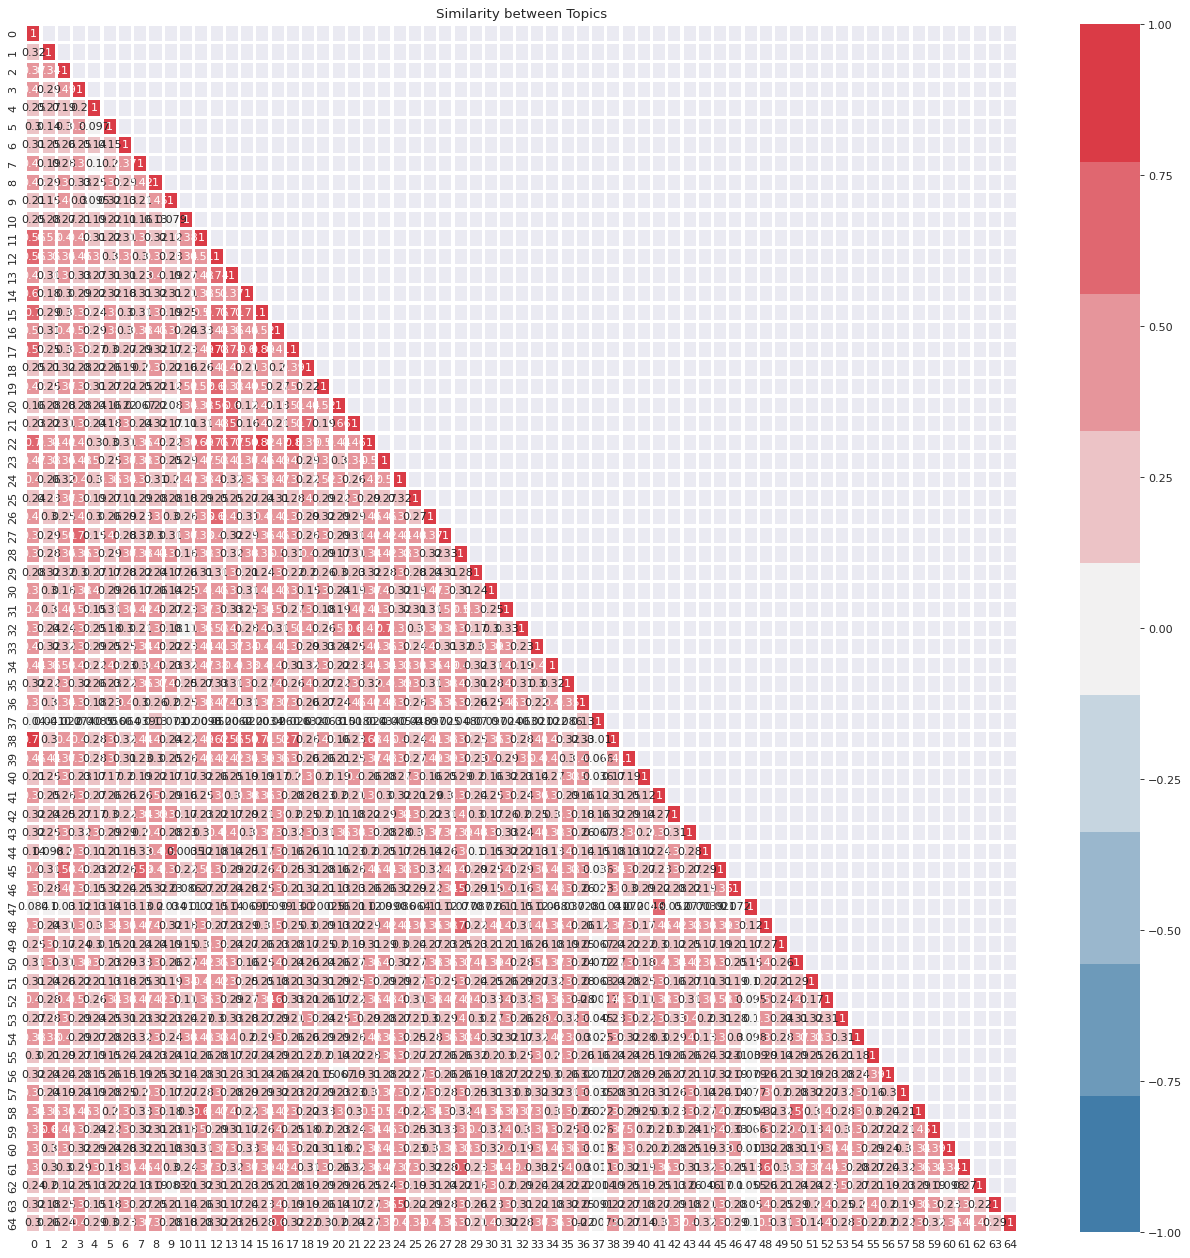

Features to be dropped:[] - 0



In [ ]:
delta_k,to_drop=CLUSTERSIMILARITY(all_tw, modelW2V)

In [ ]:
print(all_tw[16])
print(all_tw[22])

['initialize', 'scanner', 'target', 'byte', 'initialize_block', 'block_scanner', 'scanner_target', 'target_byte', 'initialize_block_scanner', 'block_scanner_target', 'scanner_target_byte']
['volume', 'scanner', 'not', 'suitable', 'pool', 'find', 'scan', 'wait', 'volume_scanner', 'scanner_not', 'not_suitable', 'suitable_block', 'block_pool', 'pool_find', 'find_scan', 'scan_wait', 'volume_scanner_not', 'scanner_not_suitable', 'not_suitable_block', 'suitable_block_pool', 'block_pool_find', 'pool_find_scan', 'find_scan_wait']


In [ ]:
model2=myBERTopic.load("bertopic.model")
new_topics, new_probs = model2.reduce_topics(sentences2, topics, probs, nr_topics=18)
print(len(model2.get_topics()))
topics45=new_topics[:45]
indexes=np.argsort(topics45)
print(len(indexes))
for i in indexes:
    print(new_topics[i], max(new_probs[i]))
    print(model2.get_topic(new_topics[i]))
    print(sentences2[i])
    print(originals[i])
    print("\n")

2022-01-21 16:11:30,936 - BERTopic - Reduced number of topics from 59 to 19


19
45
-1 0.002764888132788414
[('python', 0.11607855220446346), ('netty', 0.11607855220446346), ('start', 0.11260570384855705), ('memory_store_start', 0.07263359983099354), ('logger', 0.07263359983099354), ('transfer', 0.07263359983099354), ('store_start', 0.07263359983099354), ('store_start_capacity', 0.07263359983099354), ('time', 0.07263359983099354), ('time_total', 0.07263359983099354), ('start_executor_host', 0.07263359983099354), ('runner', 0.07263359983099354), ('server', 0.07263359983099354), ('server_create', 0.07263359983099354), ('logger_start', 0.07263359983099354), ('time_total_boot', 0.07263359983099354), ('start_executor', 0.07263359983099354), ('total', 0.07263359983099354), ('init_finish', 0.07263359983099354), ('init', 0.07263359983099354)]
python python runner time total boot init finish time_total total_boot boot_init init_finish time_total_boot total_boot_init boot_init_finish
python.PythonRunner: Times: total = 821, boot = 642, init = 176, finish = 3


-1 8.029610

In [ ]:
model3=myBERTopic.load("bertopic.model")
tp1=topic_model.get_topics()
tp2=model3.get_topics()
c=0
for i in range(len(topic_model.get_topics())-1):
    print(i,tp1[i])
    print(i,tp2[i])
    if tp1[i]==tp2[i]:
        print("OK")
        c+=1
    else:
        print("ERROR")
    print("\n")
print(f"OKs: {c}/{len(tp1)-1}")

0 [('local', 0.31515345608760026), ('disk', 0.31515345608760026), ('local_directory', 0.31515345608760026), ('create_local_directory', 0.31515345608760026), ('create_local', 0.31515345608760026), ('directory', 0.23105801172618246), ('create', 0.23105801172618246), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05)]
0 [('local', 0.31515345608760026), ('disk', 0.31515345608760026), ('local_directory', 0.31515345608760026), ('create_local_directory', 0.31515345608760026), ('create_local', 0.31515345608760026), ('directory', 0.23105801172618246), ('create', 0.23105801172618246), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05)]
OK


1 [('file', 0.1633161740813785), ('committer', 0.1633161740813785), ('output', 0.15993672778159526), ('version', 0.137879637038

In [ ]:
freq = topic_model.get_topic_info(); freq.head(len(num_topic))

,Topic,Count,Name
0,0,50,0_deprecate_mapreduce_use_configuration
1,1,40,1_block_manager_register_block_manager_registe...
2,2,30,2_stage_python_task_stage_finish
3,3,30,3_security__disable_acls_acls_yarn
4,4,30,4_hook_directory_shutdown_util
5,8,20,8_broadcast_variable_torrent_read_broadcast_va...
6,5,20,5_register_signal_register_signal_handler_regi...
7,6,20,6_unknown_driver_unknown_unknown_driver_discon...
8,7,20,7_output_committer_file_committer_algorithm
9,9,20,9_driver_disassociate_shutdown_driver_disassoc...


0.42152762543715977


In [ ]:
f=open(f"{name}_BT_RESULTS_{method}.csv","w")
for idx in range(len(sentences)):
    tw=[]
    for el in topic_model.get_topic(i):
        if len(el[0])>0:
            tw.append(el[0])
    tw_s=" ".join(tw)
    org=originals[idx].replace(","," ")
    output_str=str(topics[i])+", "+tw_s+", "+org+", "+sentences2[idx]
    print(output_str, file=f)
f.close()

Low Memory Model

**NOTE**: Use `language="multilingual"` to select a model that support 50+ languages.

## Extracting Topics
After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [ ]:
freq = topic_model.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,6604,-1_to_is_of_and
1,0,1816,0_game_team_games_he
2,1,584,1_key_clipper_chip_encryption
3,2,530,2_idjits_ites_cheek_dancing
4,3,469,3_fbi_batf_fire_koresh
5,4,422,4_car_cars_engine_ford
6,5,419,5_drive_scsi_drives_ide
7,6,322,6_israel_israeli_arab_arabs
8,7,220,7_ted_you_post_deleted
9,8,189,8_gun_guns_firearms_criminals


-1 refers to all outliers and should typically be ignored. Next, let's take a look at a frequent topic that were generated:

In [ ]:
print(len(freq))

279


In [ ]:
for i in range(20):
  tp=topic_model.get_topic(i)
  print(tp)

[('storage', 0.28451326718653774), ('blockmanager', 0.20658287271155013), ('memorystore', 0.20658287271155013), ('broadcast', 0.1573360479555701), ('block', 0.12861688337777719), ('started', 0.10329143635577506), ('slf', 0.09583768252008637), ('created', 0.09583768252008637), ('reading', 0.09583768252008637), ('as', 0.09583768252008637)]
[('task', 0.13884255091739092), ('mapred', 0.1310037729390318), ('id', 0.1240354253988696), ('is', 0.1240354253988696), ('instead', 0.11611667504961314), ('use', 0.11611667504961314), ('mapreduce', 0.11611667504961314), ('configuration', 0.11611667504961314), ('deprecated', 0.11611667504961314), ('deprecation', 0.11611667504961314)]
[('executor', 0.38505817237051554), ('coarsegrainedexecutorbackend', 0.2542726220676827), ('driver', 0.23019234387858442), ('stage', 0.10679056052238195), ('registered', 0.0955439705092059), ('task', 0.09148732372949508), ('in', 0.08765865528953191), ('to', 0.07673078129286147), ('an', 0.06312629439709426), ('disconnected',

In [ ]:
topic_model.get_topic(30)  # Select the most frequent topic

[('games', 0.042437676272290746),
 ('joystick', 0.02987521365692991),
 ('sega', 0.023600516052635176),
 ('game', 0.02065057903266744),
 ('arcade', 0.014696939175727437),
 ('525', 0.014251716675927525),
 ('super', 0.013823490198907369),
 ('offer', 0.013310156360599979),
 ('10', 0.013246908683681046),
 ('snes', 0.01316710765717177)]

**NOTE**: BERTopic is stocastich which mmeans that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

# **Visualization**
There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time. Topic modeling is, to a certain extent, quite subjective. Visualizations help understand the topics that were created. 

## Visualize Topics
After having trained our `BERTopic` model, we can iteratively go through perhaps a hundred topic to get a good 
understanding of the topics that were extract. However, that takes quite some time and lacks a global representation. 
Instead, we can visualize the topics that were generated in a way very similar to 
[LDAvis](https://github.com/cpsievert/LDAvis):

In [ ]:
topic_model.visualize_topics()

## Visualize Topic Probabilities

The variable `probabilities` that is returned from `transform()` or `fit_transform()` can 
be used to understand how confident BERTopic is that certain topics can be found in a document. 

To visualize the distributions, we simply call:

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

## Visualize Topic Hierarchy

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

## Visualize Term Score Decline
Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, the select the best number of words in a topic.


In [ ]:
topic_model.visualize_term_rank()

# **Topic Representation**
After having created the topic model, you might not be satisfied with some of the parameters you have chosen. Fortunately, BERTopic allows you to update the topics after they have been created. 

This allows for fine-tuning the model to your specifications and wishes. 

## Update Topics
When you have trained a model and viewed the topics and the words that represent them,
you might not be satisfied with the representation. Perhaps you forgot to remove
stopwords or you want to try out a different `n_gram_range`. We can use the function `update_topics` to update 
the topic representation with new parameters for `c-TF-IDF`: 


In [ ]:
topic_model.update_topics(docs, topics, n_gram_range=(1, 2))

In [ ]:
topic_model.get_topic(0)   # We select topic that we viewed before

[('space', 0.011119596146117955),
 ('nasa', 0.0047697533973351915),
 ('shuttle', 0.0044533985251824495),
 ('orbit', 0.004129278694477752),
 ('spacecraft', 0.004011023125258004),
 ('satellite', 0.003783732360211832),
 ('moon', 0.003639954930862572),
 ('lunar', 0.0034753177228921146),
 ('the moon', 0.002821040122532999),
 ('mars', 0.0028033947303940923)]

## Topic Reduction
We can also reduce the number of topics after having trained a BERTopic model. The advantage of doing so, 
is that you can decide the number of topics after knowing how many are actually created. It is difficult to 
predict before training your model how many topics that are in your documents and how many will be extracted. 
Instead, we can decide afterwards how many topics seems realistic:





In [ ]:
new_topics, new_probs = topic_model.reduce_topics(docs, topics, probs, nr_topics=60)

2021-10-17 06:05:02,666 - BERTopic - Reduced number of topics from 220 to 61


# **Search Topics**
After having trained our model, we can use `find_topics` to search for topics that are similar 
to an input search_term. Here, we are going to be searching for topics that closely relate the 
search term "vehicle". Then, we extract the most similar topic and check the results: 

In [ ]:
similar_topics, similarity = topic_model.find_topics("vehicle", top_n=5); similar_topics

[71, 45, 77, 9, 56]

In [ ]:
topic_model.get_topic(71)

[('car', 0.03740731827314482),
 ('the car', 0.027790363401304377),
 ('dealer', 0.013837911908704722),
 ('the dealer', 0.009515109324321468),
 ('owner', 0.008430722097917726),
 ('previous owner', 0.008157988442865012),
 ('cars', 0.005827046491488879),
 ('the odometer', 0.00514870077683653),
 ('bought car', 0.004667512506960727),
 ('car with', 0.004498685875558186)]

# **Model serialization**
The model and its internal settings can easily be saved. Note that the documents and embeddings will not be saved. However, UMAP and HDBSCAN will be saved. 

In [ ]:
# Save model
topic_model.save("my_model")	

In [ ]:
# Load model
my_model = BERTopic.load("my_model")	

# **Embedding Models**
The parameter `embedding_model` takes in a string pointing to a sentence-transformers model, a SentenceTransformer, or a Flair DocumentEmbedding model.

## Sentence-Transformers
You can select any model from sentence-transformers here and pass it through BERTopic with embedding_model:



In [ ]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

Or select a SentenceTransformer model with your own parameters:


In [ ]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
topic_model = BERTopic(embedding_model=sentence_model, verbose=True)

Click [here](https://www.sbert.net/docs/pretrained_models.html) for a list of supported sentence transformers models.  
